In [1]:
import sys
import os
import numpy as np
import sympy as sp

# Add the parent directory and src directory to Python path
project_root = os.path.dirname(os.getcwd())
src_path = os.path.join(project_root, 'src')
sys.path.insert(0, project_root)
sys.path.insert(0, src_path)

# First import matrix_utils to make it available for seesaw module
#import matrix_utils

# Now we need to temporarily fix the import issue by importing functions into global namespace
from matrix_utils import (diagonalize_mass_matrix, mass_squared_differences,
                          create_symbolic_matrix, seesaw_approximation_symbolic,
                          substitute_numerical_values, symbolic_rotation_matrix,
                          sin_cos_from_tan_fraction)

# Add these to matrix_utils module namespace to satisfy relative imports
sys.modules['matrix_utils'].diagonalize_mass_matrix = diagonalize_mass_matrix
sys.modules['matrix_utils'].mass_squared_differences = mass_squared_differences
sys.modules['matrix_utils'].create_symbolic_matrix = create_symbolic_matrix
sys.modules['matrix_utils'].seesaw_approximation_symbolic = seesaw_approximation_symbolic
sys.modules['matrix_utils'].substitute_numerical_values = substitute_numerical_values
sys.modules['matrix_utils'].symbolic_rotation_matrix = symbolic_rotation_matrix
sys.modules['matrix_utils'].sin_cos_from_tan_fraction = sin_cos_from_tan_fraction

# Now import seesaw with absolute imports instead of relative
exec(open(os.path.join(src_path, 'seesaw.py')).read().replace('from .matrix_utils import', 'from matrix_utils import'))

print("Successfully loaded SymbolicSeesawTypeI!")
print(f"Available methods: {[method for method in dir(SymbolicSeesawTypeI) if not method.startswith('_')]}")

Successfully loaded SymbolicSeesawTypeI!
Available methods: ['MConjugateMT', 'MDaggerM', 'charpoly_relations', 'evaluate_numerically', 'full_mass_matrix_symbolic', 'left_eigenvectors', 'light_mass_matrix_symbolic', 'neutrino_mass_differences_dummyes', 'perturbative_expansion', 'right_eigenvectors', 'scaling_analysis', 'set_texture', 'simplified_2x2_case']


# One generation of each neutrino case

In [2]:
from sympy import init_printing, symbols, solve, sin, cos, factor, Matrix, conjugate, I, sqrt, tan, Dummy
from sympy.physics.quantum import Dagger
init_printing()

# Two left neutrinos and o right handed neutrino

In [3]:
seesaw21 = SymbolicSeesawTypeI(n_generations=2, n_sterile=1)
seesaw21

SymbolicSeesawTypeI(n_generations=2, n_sterile=1)

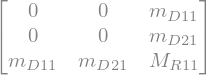

In [4]:
Mnu21 = seesaw21.full_mass_matrix_symbolic()
Mnu21

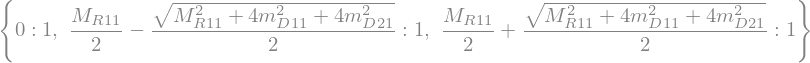

In [5]:
Mnu21.eigenvals()

In [6]:
charpoly_relations = seesaw21.charpoly_relations()


In [7]:
mn = seesaw21.masses
mn

In [8]:
charpoly_relations['char_poly_M']

In [9]:
charpoly_relations['char_poly_diag'].subs(mn[0], 0)

In [10]:
eqs_charpoly = [
    charpoly_relations['coefficients_full_matrix'][key] 
    - charpoly_relations['coefficients_diagonal'][key].subs(mn[0], 0)
    for key in charpoly_relations['coefficients_full_matrix']
]
eqs_charpoly

In [11]:
r = symbols('r')
th = symbols('theta', real=True)
seesaw_parameters_polar = {seesaw21.m_D_sym[0, 0]: r * sin(th), seesaw21.m_D_sym[1, 0]: r * cos(th)}
(seesaw21.m_D_sym[0, 0]**2 + seesaw21.m_D_sym[1, 0]**2).subs(
    seesaw_parameters_polar
).trigsimp()

In [12]:
r_masses = I*sqrt(mn[1])*sqrt(mn[2])
r_masses, r_masses**2

In [13]:
seesaw_parameters_polar_masses = {
    seesaw21.m_D_sym[0, 0]: r_masses * sin(th),
    seesaw21.m_D_sym[1, 0]: r_masses * cos(th)
}
seesaw_parameters_polar_masses

In [14]:
seesaw_parameters_polar_masses[seesaw21.M_R_sym[0, 0]] = solve(eqs_charpoly[2], seesaw21.M_R_sym[0, 0])[0]

In [15]:
seesaw_parameters_polar_masses

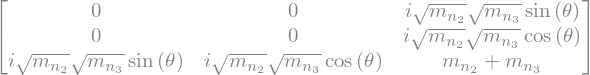

In [16]:
Mnu21_polar = Mnu21.subs(seesaw_parameters_polar_masses)
Mnu21_polar

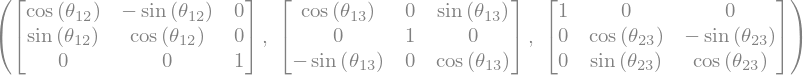

In [ ]:
th12, th23 = symbols(r'\theta_{12}, \theta_{23}', real=True)
Rth12 = symbolic_rotation_matrix(dim=3, axis=2, angle=th12)
Rth23 = symbolic_rotation_matrix(dim=3, axis=0, angle=th23)
Rth12, Rth23

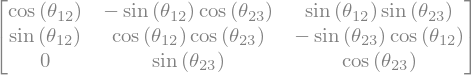

In [18]:
R = Rth12*Rth23
R

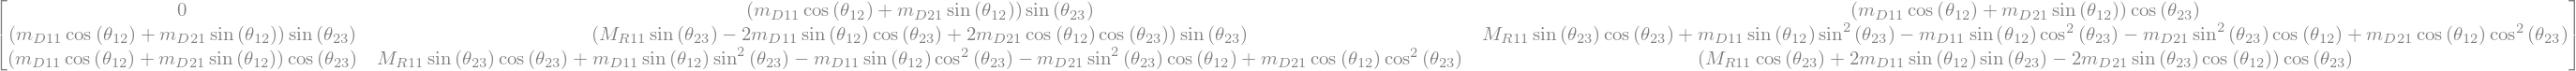

In [19]:
Mnu21_diag = (R.T*Mnu21*R).applyfunc(lambda x:x.factor())
Mnu21_diag

In [20]:
Mnu21_diag[0, 1]

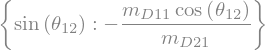

In [21]:
sinth12_sol = solve(Mnu21_diag[0, 1], sin(th12), dict=True)[0]
sinth12_sol

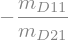

In [22]:
tanth12 = sinth12_sol[sin(th12)]/cos(th12)
tanth12

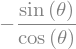

In [23]:
tanth12.subs(seesaw_parameters_polar_masses)

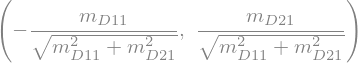

In [91]:
sinth12, costh12 = sin_cos_from_tan_fraction(tanth12)
sinth12, costh12 

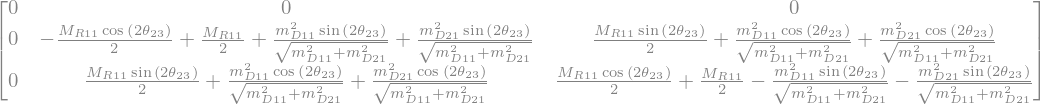

In [96]:
Mnu21_diag_th23 = Mnu21_diag.subs(
    {
        sin(th12): sinth12,
        cos(th12): costh12
    }
).applyfunc(lambda x:x.trigsimp())
Mnu21_diag_th23

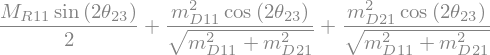

In [97]:
Mnu21_diag_th23[1,2]

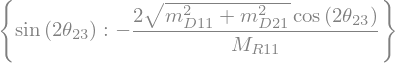

In [100]:
sin2th23_sol = solve(Mnu21_diag_th23[1, 2], sin(2*th23), dict=True)[0]
sin2th23_sol

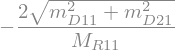

In [101]:
tan2th23 = sin2th23_sol[sin(2*th23)]/cos(2*th23)
tan2th23

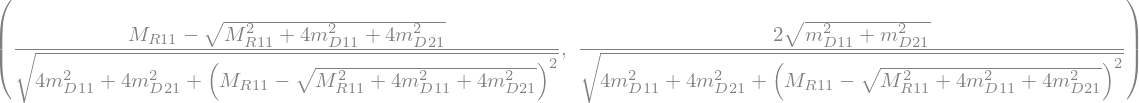

In [102]:
sin2th23, cos2th23 = sin_cos_from_tan_fraction(tan2th23)
#display(sin2th, cos2th)
tanth23 = ((1 - cos2th23)/sin2th23).factor()
sinth23, costh23 = sin_cos_from_tan_fraction(tanth23)
sinth23, costh23

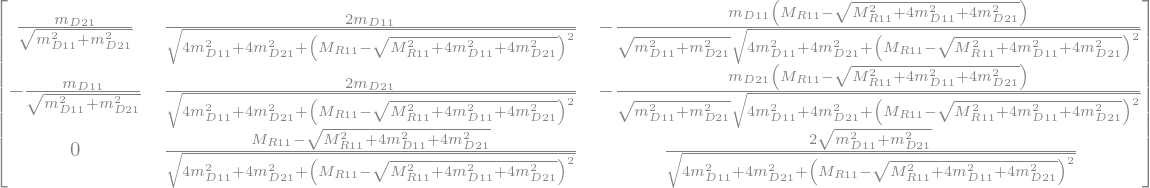

In [104]:
Rth_seesaw = R.subs(
    {
        sin(th12):sinth12,
        cos(th12):costh12
    }
).subs(
    {
        sin(th23):sinth23,
        cos(th23):costh23
    }
)
Rth_seesaw

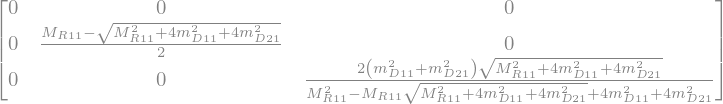

In [126]:
Mnu21_masses = (Rth_seesaw.T*Mnu21*Rth_seesaw).applyfunc(lambda x:x.factor())
Mnu21_masses

In [118]:
sinth12_masses = sinth12.subs(seesaw_parameters_polar_masses).factor(deep=True).trigsimp()
sinth12_masses

In [120]:
costh12_masses = costh12.subs(seesaw_parameters_polar_masses).factor(deep=True).trigsimp()
costh12_masses

In [121]:
dummy_differences = seesaw21.neutrino_mass_differences_dummyes()
dummy_differences

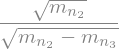

In [122]:
sinth23_masses = sinth23.subs(seesaw_parameters_polar_masses).factor(deep=True).trigsimp().subs(dummy_differences).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor()
sinth23_masses

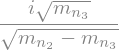

In [123]:
costh23_masses = costh23.subs(seesaw_parameters_polar_masses).factor(deep=True).trigsimp().subs(dummy_differences).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor()
costh23_masses

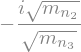

In [130]:
tanth23_masses = sinth23_masses/costh23_masses
tanth23_masses

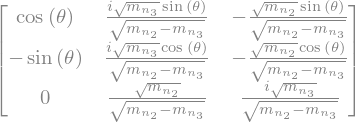

In [125]:
Rth_seesaw2 = R.subs(
    {
        sin(th12):sinth12_masses,
        cos(th12):costh12_masses
    }
).subs(
    {
        sin(th23):sinth23_masses,
        cos(th23):costh23_masses
    }
)
Rth_seesaw2

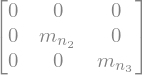

In [129]:
Mnu21_masses_polar = (Rth_seesaw2.T*Mnu21_polar*Rth_seesaw2).applyfunc(
    lambda x:x.factor().trigsimp().subs(dummy_differences).simplify().subs(
        {value:key for key, value in dummy_differences.items()}
    ).factor()
)
Mnu21_masses_polar